Changelog
- 30 Sep 2019
    - Creation
    - Goal is to do MOBIL experimentation to demonstrate lane changes
    - Idea flow
        - Look at some videos to select a situation with enough spacing to make lane change
        - Select a vehicle id that is on a slow lane
        - Make it want to make a lange change by some selection of parameters
- 2 Oct
    - Defining in notebook copies of `MOBIL` and `Tim2DDriver` for debugging purposed
    - Above did not work because methods being redefined not working (or something like that)
    - Found that Maxime had a commit on June 18 fixing MOBIL.jl. Did a git pull 
    on `.julia/packages/dev/AutomotiveDrivingModels`
    - Seems to change lane
- 3 Oct
    - Influence of stochastictity on the `ProportionalLaneTracker`
    - trace the x and y positions of car
- 10 Oct
    - Function to get the lane id

In [41]:
# using packages
using NGSIM
using AutomotiveDrivingModels
using AutoViz
using Reel
using Distributions
using Random
using PGFPlots
using LinearAlgebra # To make the MvNormal covariance work maybe
using JLD

In [2]:
# define global things: timestep, roadway, traj
timestep_ngsim = 0.1;

In [3]:
# overlays: IDOverlay. my_overlay
"""
    IDOverlay
Display the ID on top of each entity in a scene.
# Fields
- `color::Colorant`
- `font_size::Int64`
"""
mutable struct IDOverlay <: SceneOverlay
    color::Colorant
    font_size::Int
end

function AutoViz.render!(rendermodel::RenderModel, overlay::IDOverlay, scene::Scene, 
                            env::E) where E
    font_size = overlay.font_size
    for veh in scene
        add_instruction!(rendermodel, render_text, ("$(veh.id)", veh.state.posG.x, 
                        veh.state.posG.y, font_size, overlay.color), incameraframe=true)
    end
    return rendermodel
end

"""
    my_overlay
Overlaying hallucinated trajectory on the ground truth
# Fields
- `color::Colorant`
- `scene::Scene`
"""
struct my_overlay <: SceneOverlay
    scene::Scene
    color # Needs to be of form colorant"Colorname"
end

function AutoViz.render!(rendermodel::RenderModel,overlay::my_overlay, 
        scene::Scene, roadway::Roadway)
    AutoViz.render!(rendermodel,overlay.scene,car_color = overlay.color)
    return rendermodel
end

In [4]:
# function: get lane id
"""
    function get_lane_id(scene,car_id)
# Examples
```julia
get_lane_id(scene,1)
```
"""
function get_lane_id(scene,car_id)
    veh = scene[findfirst(car_id,scene)]
    return veh.state.posF.roadind.tag.lane
end

get_lane_id

In [5]:
# function: generate roadway and place cars
"""
    function init_place_cars(lane_place_array;road_length = 1000.0)
- Place cars on a straight roadway of `road_length` according to elems in `lane_place_array`

# Examples
```julia
pos_vel_array_1 = [(200.,30.),(215.,0.),(220.,0.)]
pos_vel_array_2 = [(200.,0.),(215.,0.),(220.,20.)]
pos_vel_array_3 = [(215.,0.),(225.,10.),(230.,0.)]
lane_place_array = [pos_vel_array_1,pos_vel_array_2,pos_vel_array_3]
scene,roadway = init_place_cars(lane_place_array)
```
"""
function init_place_cars(lane_place_array;road_length = 1000.0)
    num_lanes = length(lane_place_array)
    roadway = gen_straight_roadway(num_lanes,road_length)
    scene = Scene()

    id = 1
    for i in 1:num_lanes
        for j in 1:length(lane_place_array[i])
            veh_state = VehicleState(Frenet(roadway[LaneTag(1,i)],
                    lane_place_array[i][j][1]),roadway,
                lane_place_array[i][j][2])
            veh = Vehicle(veh_state,VehicleDef(),id)
            push!(scene,veh)
            id+=1
        end
    end
    return scene,roadway
end

init_place_cars

In [6]:
# function: make video from scene list, make video with overlay from additional scenelist
"""
    function scenelist2video
- Make video from a list of scenes

# Examples
```julia
scenelist2video(scene_list,roadway=roadway)
```
"""
function scenelist2video(scene_list;roadway,
    filename = "media/mobil/scene_to_video.mp4")
    frames = Frames(MIME("image/png"),fps = 10)
    
    # Loop over list of scenes and convert to video
    for i in 1:length(scene_list)
        scene_visual = render(scene_list[i],roadway,
        [IDOverlay(colorant"white",12)],
#         cam=FitToContentCamera(0.),
        cam = CarFollowCamera(1)
        )
        push!(frames,scene_visual)
    end
    print("Making video filename: $(filename)\n")
    write(filename,frames)
    return nothing
end

"""
    function scenelist2video
- Make video from a list of scenes

# Examples
```julia
scenelist2video(scene_list,roadway=roadway)
```
"""
function multiple_scenelist2video(scene_list_1,scene_list_2;roadway,
    filename = "media/mobil/multiple_scene_to_video.mp4")
    frames = Frames(MIME("image/png"),fps = 10)
    @assert length(scene_list_1) == length(scene_list_2)
    # Loop over list of scenes and convert to video
    for i in 1:length(scene_list)
        other_overlay = my_overlay(scene_list_2[i],colorant"blue")
        scene_visual = render(scene_list[i],roadway,
        [IDOverlay(colorant"white",12),other_overlay],
#         cam=FitToContentCamera(0.),
        cam = CarFollowCamera(1)
        )
        push!(frames,scene_visual)
    end
    print("Making video filename: $(filename)\n")
    write(filename,frames)
    return nothing
end

multiple_scenelist2video

In [7]:
# function: hallucinate scene list
"""
    function get_hallucination_scenes
- Hallucinate starting from `start_step` for `nsteps` using `models` and return a list of scenes
- Used by `plot_carwise_pos_vel` to assess position and velocity traces against ground truth

# Returns
- `halluc_scenes_list`: List containing the scenes starting with the ground truth scene at `start_step`

# Examples
```julia
scene_list = get_hallucination_scenes(start_scene,nsteps=100,models=models,
roadway=roadway);
```
"""
function get_hallucination_scenes(start_scene;nsteps,models,start_step=1,
        id_list=[],roadway,timestep=0.1,verbosity = false)
        # Setting up
    scene_halluc = start_scene
    halluc_scenes_list = []
#     scene_halluc = get_scene(start_step,traj) # Frame to start hallucination from
#     push!(halluc_scenes_list,deepcopy(scene_halluc))
    
    for (i,t) in enumerate(start_step:start_step+nsteps-1)
        
#         if !isempty(id_list) keep_vehicle_subset!(scene_halluc,id_list) end
        
        actions = Array{Any}(undef,length(scene_halluc))

            # Propagation of scene forward
        get_actions!(actions,scene_halluc,roadway,models)

        tick!(scene_halluc,roadway,actions,timestep)
        
        push!(halluc_scenes_list,deepcopy(scene_halluc))
    end 
    return halluc_scenes_list
end

get_hallucination_scenes

In [8]:
# script: Place cars on a straight roadway and generate driving video
pos_vel_array_1 = [(200.,30.),(250.,0.)]
pos_vel_array_2 = [(250.,10.)]
pos_vel_array_3 = [(215.,0.),(225.,10.),(230.,0.)]
lane_place_array = [pos_vel_array_1,pos_vel_array_2]
scene,roadway = init_place_cars(lane_place_array)

models = Dict{Int64,DriverModel}()
for veh in scene
#     print("veh.id = $(veh.id)\n")
#     models[veh.id] = LatLonSeparableDriver(ProportionalLaneTracker(),IntelligentDriverModel())
    models[veh.id] = IntelligentDriverModel()
end
politeness = 0.
models[1] = Tim2DDriver(timestep_ngsim,mlane=MOBIL(timestep_ngsim,politeness=politeness))
models[2] = IntelligentDriverModel(v_des=15.)

scene_list = get_hallucination_scenes(scene,nsteps=100,models=models,roadway=roadway);
#scenelist2video(scene_list,roadway=roadway,filename="media/mobil/polite_$(politeness)_lane_change.mp4")

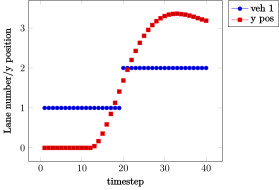

In [25]:
# plot: Lane id and y position overlap together to assess quantization of time
numsteps = 40
p1 = PGFPlots.Plots.Scatter(collect(1:numsteps),
    [get_lane_id(scene,1) for scene in scene_list[1:numsteps]],legendentry="veh 1")
p2 = PGFPlots.Plots.Scatter(collect(1:numsteps),
    [get_lane_id(scene,2) for scene in scene_list[1:numsteps]],legendentry="veh 2")
p3 = PGFPlots.Plots.Scatter(collect(1:numsteps),
    [get_lane_id(scene,3) for scene in scene_list[1:numsteps]],legendentry="veh 3")
py1 = PGFPlots.Plots.Scatter(collect(1:numsteps),
    [scene[1].state.posG.y for scene in scene_list[1:numsteps]],legendentry = "y pos")
PGFPlots.Axis([p1,py1],xlabel="timestep",ylabel="Lane number/y position",legendPos="outer north east")

In [ ]:
# experiment: run starting from a scene to see what happens
start_scene = deepcopy(scene_list[10])
scene_list_quantization = get_hallucination_scenes(start_scene; nsteps=90,models=models,roadway=roadway)

In [ ]:
# Compare two politeness values in one video by overlaying
pos_vel_array_1 = [(200.,30.),(250.,0.)]
pos_vel_array_2 = [(250.,10.)]
pos_vel_array_3 = [(215.,0.),(225.,10.),(230.,0.)]
lane_place_array = [pos_vel_array_1,pos_vel_array_2]
scene,roadway = init_place_cars(lane_place_array)
start_scene = deepcopy(scene)
models_1 = Dict{Int64,DriverModel}()
models_2 = Dict{Int64,DriverModel}()
for veh in scene
    models_1[veh.id] = IntelligentDriverModel()
    models_2[veh.id] = IntelligentDriverModel()
end
politeness = 0.
models_1[1] = Tim2DDriver(timestep_ngsim,mlane=MOBIL(timestep_ngsim,politeness=politeness))
models_1[2] = IntelligentDriverModel(v_des=15.)

scene_list_1 = get_hallucination_scenes(scene,nsteps=100,models=models_1,roadway=roadway)

politeness = 1.
models_2[1] = Tim2DDriver(timestep_ngsim,mlane=MOBIL(timestep_ngsim,politeness=politeness))
models_2[2] = IntelligentDriverModel(v_des=15.)

scene_list_2 = get_hallucination_scenes(start_scene,nsteps=100,models=models_2,roadway=roadway)
multiple_scenelist2video(scene_list_1,scene_list_2,roadway=roadway,
    filename="media/mobil/compare_politeness.mp4")

In [ ]:
# Compare two advantage_threshold values in one video by overlaying
pos_vel_array_1 = [(200.,30.),(250.,0.)]
pos_vel_array_2 = [(250.,10.)]
pos_vel_array_3 = [(215.,0.),(225.,10.),(230.,0.)]
lane_place_array = [pos_vel_array_1,pos_vel_array_2]
scene,roadway = init_place_cars(lane_place_array)
start_scene = deepcopy(scene)
models_1 = Dict{Int64,DriverModel}()
models_2 = Dict{Int64,DriverModel}()
for veh in scene
    models_1[veh.id] = IntelligentDriverModel()
    models_2[veh.id] = IntelligentDriverModel()
end
politeness = 0.
a_th = 0.
models_1[1] = Tim2DDriver(timestep_ngsim,
    mlane=MOBIL(timestep_ngsim,politeness=politeness,advantage_threshold=a_th))
models_1[2] = IntelligentDriverModel(v_des=15.)

scene_list_1 = get_hallucination_scenes(scene,nsteps=100,models=models_1,roadway=roadway)

politeness = 0.
a_th = 1.
models_2[1] = Tim2DDriver(timestep_ngsim,
    mlane=MOBIL(timestep_ngsim,politeness=politeness,advantage_threshold=a_th))
models_2[2] = IntelligentDriverModel(v_des=15.)

scene_list_2 = get_hallucination_scenes(start_scene,nsteps=100,models=models_2,roadway=roadway)
multiple_scenelist2video(scene_list_1,scene_list_2,roadway=roadway,
    filename="media/mobil/compare_adv_blueHighThreshold_p_0.mp4")

In [ ]:
# Influence of stochasticity on lateral driving
seed=3;
Random.seed!(seed) # To control the stochasticity in ProportionalLaneTracker

pos_vel_array_1 = [(200.,30.),(250.,0.)]
pos_vel_array_2 = [(250.,10.)]
pos_vel_array_3 = [(215.,0.),(225.,10.),(230.,0.)]
lane_place_array = [pos_vel_array_1,pos_vel_array_2]
scene,roadway = init_place_cars(lane_place_array)
start_scene = deepcopy(scene)
models_1 = Dict{Int64,DriverModel}()
models_2 = Dict{Int64,DriverModel}()
for veh in scene
    models_1[veh.id] = IntelligentDriverModel()
    models_2[veh.id] = IntelligentDriverModel()
end
models_1[1] = Tim2DDriver(timestep_ngsim,
    mlane=MOBIL(timestep_ngsim),
    mlat=ProportionalLaneTracker()
)
models_1[2] = IntelligentDriverModel(v_des=15.)

scene_list_1 = get_hallucination_scenes(scene,nsteps=100,models=models_1,roadway=roadway)

sigma_lat = 10.
models_2[1] = Tim2DDriver(timestep_ngsim,
    mlane=MOBIL(timestep_ngsim),
    mlat=ProportionalLaneTracker(σ=sigma_lat)
)
models_2[2] = IntelligentDriverModel(v_des=15.)

scene_list_2 = get_hallucination_scenes(start_scene,nsteps=100,models=models_2,roadway=roadway)
multiple_scenelist2video(scene_list_1,scene_list_2,roadway=roadway,
    filename="media/mobil/lateral_blueIsStochastic_$(seed)_seed_sigmaLat_$(sigma_lat).mp4")

In [ ]:
# Let's plot the x,y trace of car 1
x = fill(0.,length(scene_list_1),2)
y = fill(0.,length(scene_list_1),2)
for (i,scene) in enumerate(scene_list_1)
    x[i,1] = scene[findfirst(1,scene)].state.posG.x
    y[i,1] = scene[findfirst(1,scene)].state.posG.y
    x[i,2] = scene[findfirst(2,scene)].state.posG.x
    y[i,2] = scene[findfirst(2,scene)].state.posG.y
end
car1 = PGFPlots.Plots.Scatter(x[:,1],y[:,1],legendentry="follower")
car2 = PGFPlots.Plots.Scatter(x[:,2],y[:,2],legendentry="leader")
laneboundary0 = PGFPlots.Plots.Linear(x[:,1],fill(-1.5,length(scene_list_1)),
    style="black,ultra thick",legendentry="lane edge")
laneboundary1 = PGFPlots.Plots.Linear(x[:,1],fill(1.5,length(scene_list_1)),style="black,ultra thick")
laneboundary2 = PGFPlots.Plots.Linear(x[:,1],fill(4.5,length(scene_list_1)),style="black,ultra thick")

mystyle = "{draw=none,at={(0.5,-0.2)},anchor=north,legend columns=3,
          /tikz/every even column/.append style={column sep=0.2cm}}"
PGFPlots.Axis([car1,car2,laneboundary0,laneboundary1,laneboundary2],xlabel="x",ylabel="y",legendStyle=mystyle)

#### bivariate normal to experiment with the noise in proportional lane tracker

In [ ]:
d = MvNormal([0.,0.],[1. 0.;0. 1.])

In [ ]:
pdf(d,[0.5,-0.5])

In [35]:
# Lets think of a hybrid discrete and continuous distribution
b = Bernoulli(0.3)
rand(b,50)
pdf(b,0)
d = Normal(0,1)
pdf(b,0)*pdf(d,0.4)

0.2577890982123263

#### implement functions for hallucination

In [ ]:
"""
- Hallucinate using a particle, return its likelihood
"""
particle = [politeness, sigma_lat]
model = Tim2DDriver(timestep_ngsim,mlane=MOBIL(timestep_ngsim,politeness=particle[1]),
    mlat=ProportionalLaneTracker(σ=particle[2])
)
get_actions!
tick!

compute the likelihood 

In [45]:
function overlay_jld_scenelists(num_exps)
    horizon = 100
    list_of_plots = PGFPlots.Plot[]
    for i in 1:num_exps
        scene_list = JLD.load("media/mobil/$(i).jld","scene_list")
        p = PGFPlots.Plots.Scatter(collect(1:horizon),
            [scene[1].state.posG.y for scene in scene_list[1:horizon]],
            legendentry = "scenario $(i)")
        push!(list_of_plots,p)
    end
    pa = PGFPlots.Axis(list_of_plots,xlabel="timestep",ylabel="y pos",
        legendPos="outer north east")
    display(pa)
    PGFPlots.save("media/mobil/sensor_noise_impact.pdf",pa)
    return nothing
end

overlay_jld_scenelists (generic function with 2 methods)

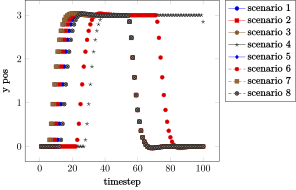

In [47]:
overlay_jld_scenelists(8)